# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [ ]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [ ]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [ ]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [ ]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [ ]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [ ]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

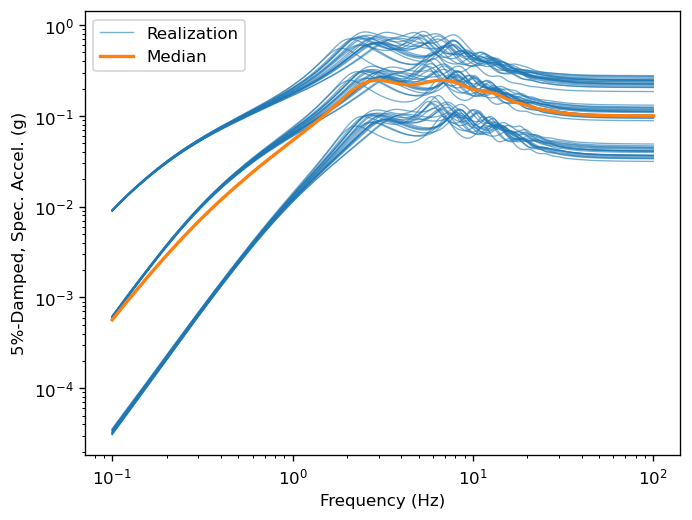

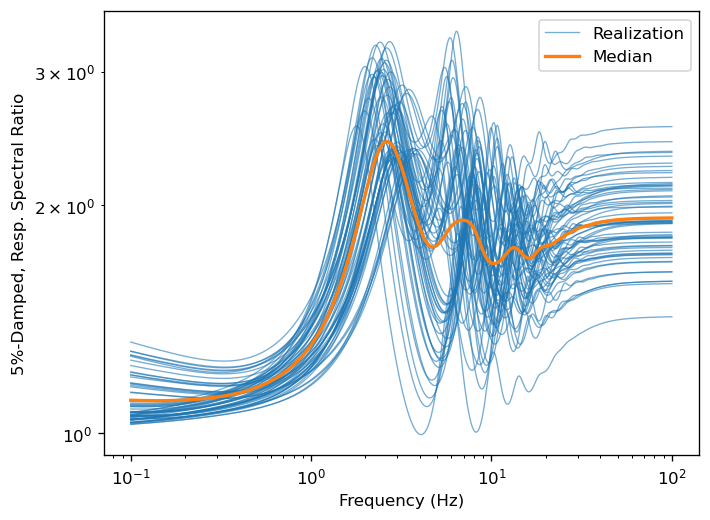

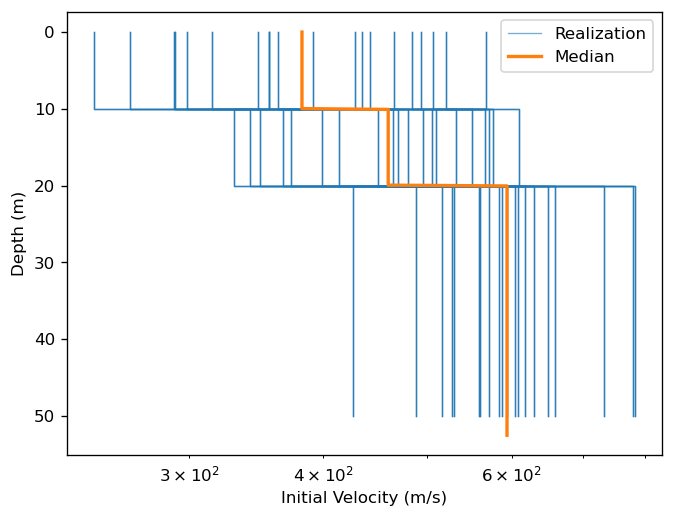

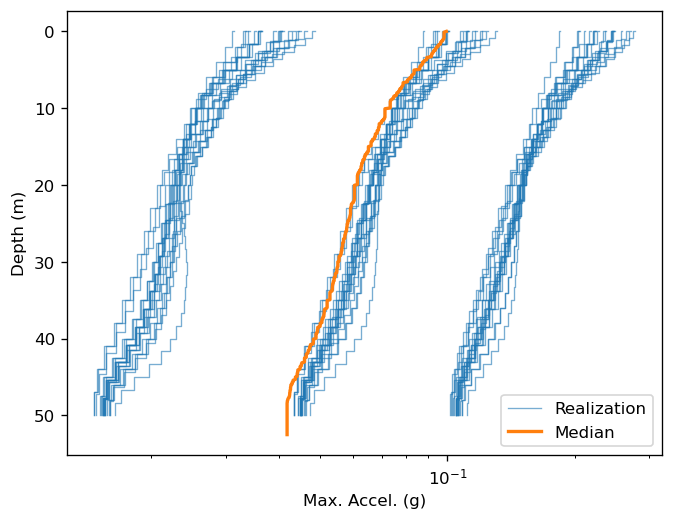

In [ ]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [ ]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.319894  1.103468  1.065328  1.132238  1.045642  1.028495   
0.101394    1.318626  1.103357  1.065810  1.131890  1.045626  1.028725   
0.102807    1.317362  1.103251  1.066296  1.131544  1.045614  1.028957   
0.104240    1.316102  1.103153  1.066789  1.131200  1.045606  1.029192   
0.105693    1.314846  1.103061  1.067286  1.130857  1.045602  1.029429   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.272257  2.119480  1.890790  2.105968  1.988629  1.919438   
95.932095   2.272363  2.119596  1.890933  2.105989  1.988640  1.919472   
97.269336   2.272466  2.119708  1.891071  2.106009  1.988651  1.919504   
98.625218   2.272565  2.119816  1.891205  2.106028  1.988661  1.919536   
100.000000  2.272662  2.119922  1.891336  2.106047  1.988671  1.919566   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.203260  1.069131  1.043541  1.194517  ...  1.033551  1.264327   
0.101394    1.202586  1.069081  1.043878  1.193818  ...  1.033817  1.263241   
0.102807    1.201915  1.069035  1.044219  1.193122  ...  1.034086  1.262159   
0.104240    1.201246  1.068995  1.044563  1.192428  ...  1.034357  1.261080   
0.105693    1.200580  1.068960  1.044911  1.191738  ...  1.034631  1.260005   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   2.142429  2.028331  1.906546  1.744104  ...  1.632857  1.633646   
95.932095   2.142493  2.028390  1.906630  1.744166  ...  1.632910  1.633726   
97.269336   2.142554  2.028447  1.906711  1.744225  ...  1.632962  1.633805   
98.625218   2.142614  2.028502  1.906790  1.744283  ...  1.633012  1.633880   
100.000000  2.142671  2.028556  1.906866  1.744339  ...  1.633060  1.633954   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.085357  1.052039  1.229107  1.077180  1.048854  1.283962   
0.101394    1.085270  1.052437  1.228302  1.077116  1.049227  1.282946   
0.102807    1.085190  1.052840  1.227498  1.077056  1.049603  1.281934   
0.104240    1.085115  1.053247  1.226698  1.077002  1.049984  1.280924   
0.105693    1.085048  1.053658  1.225900  1.076954  1.050368  1.279919   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.587455  1.424979  2.050047  1.953719  1.814210  2.538400   
95.932095   1.587546  1.425082  2.050130  1.953800  1.814314  2.538512   
97.269336   1.587634  1.425182  2.050212  1.953879  1.814416  2.538620   
98.625218   1.587719  1.425279  2.050291  1.953955  1.814514  2.538725   
100.000000  1.587802  1.425373  2.050367  1.954029  1.814609  2.538827   

                                
                  m1        m2  
0.100000    1.096940  1.064475  
0.101394    1.096846  1.064948  
0.102807    1.096757  1.065426  
0.104240    1.096675  1.065909  
0.105693    1.096598  1.066397  
...              ...       ...  
94.613238   2.355189  2.134277  
95.932095   2.355306  2.134435  
97.269336   2.355420  2.134588  
98.625218   2.355531  2.134737  
100.000000  2.355638  2.134881  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [ ]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.319894
0.101394,p0,m0,1.318626
0.102807,p0,m0,1.317362
0.104240,p0,m0,1.316102
0.105693,p0,m0,1.314846
...,...,...,...
94.613238,p19,m2,2.134277
95.932095,p19,m2,2.134435
97.269336,p19,m2,2.134588


In [ ]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.209840  0.044999
           m1      1.070804  0.016350
           m2      1.044672  0.011202
0.101394   m0      1.209118  0.044817
           m1      1.070748  0.016325
...                     ...       ...
98.625218  m1      1.935428  0.106146
           m2      1.805359  0.101148
100.000000 m0      2.038320  0.118784
           m1      1.935488  0.106149
           m2      1.805439  0.101151

[1500 rows x 2 columns]

In [ ]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.044999  1.209840  0.016350  1.070804  0.011202  1.044672
0.101394    0.044817  1.209118  0.016325  1.070748  0.011275  1.045014
0.102807    0.044635  1.208398  0.016300  1.070698  0.011349  1.045360
0.104240    0.044453  1.207680  0.016276  1.070652  0.011423  1.045710
0.105693    0.044271  1.206965  0.016253  1.070612  0.011498  1.046062
...              ...       ...       ...       ...       ...       ...
94.613238   0.118776  2.038063  0.106136  1.935239  0.101137  1.805103
95.932095   0.118778  2.038130  0.106139  1.935304  0.101141  1.805191
97.269336   0.118780  2.038195  0.106143  1.935367  0.101144  1.805276
98.625218   0.118782  2.038259  0.106146  1.935428  0.101148  1.805359
100.000000  0.118784  2.038320  0.106149  1.935488  0.101151  1.805439

[500 rows x 6 columns]

Access the properties of each motion like:

In [ ]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.044999,1.209840
0.101394,0.044817,1.209118
0.102807,0.044635,1.208398
0.104240,0.044453,1.207680
0.105693,0.044271,1.206965
...,...,...
94.613238,0.118776,2.038063
95.932095,0.118778,2.038130
97.269336,0.118780,2.038195


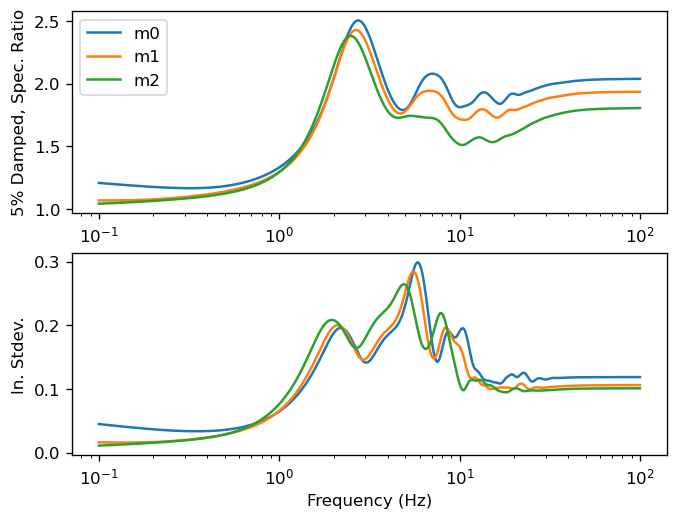

In [ ]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;